In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root = './data', train = True, download = True , transform = transform)
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)

100%|██████████| 9912422/9912422 [00:00<00:00, 109740142.02it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 45065362.29it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29190213.77it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8082532.36it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
device = torch.device("cuda")
print(device)

cuda


In [4]:
class FVSBN(nn.Module):
    def __init__(self, input_dim):
        super(FVSBN, self).__init__()

        self.weights = nn.Parameter(torch.triu(torch.randn(784,784),diagonal = 1))

    def forward(self, x):
        
        x = torch.matmul(x, self.weights)
#         x = torch.sigmoid(x)
        return x
    
    def zero_out_lower_tri_gradients(self,):
        self.weights.data = torch.triu(self.weights.data*torch.ones(784,784,device=device),diagonal=1)

        
    def sample(self, x, output_dim):
        
        sampled_image = torch.zeros(output_dim).to(device)
        sampled_image[0] = x
        
        for pixel in range(1,784):
            
            new_pixel = sampled_image.matmul(self.weights[:,pixel]).to(device)
            sampled_image[pixel] = new_pixel
            
        return sampled_image
            
            
                
                
        

In [12]:
model = FVSBN(784)
model.to(device)

FVSBN()

In [13]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [14]:
num_epochs = 50

for epoch in range(num_epochs):
    total_loss = 0.0
    for images, _ in train_loader:
        optimizer.zero_grad()
        images = images.view(images.shape[0], -1)
        images = images.to(device)
        output = model(images)
        output.to(device)
        loss = criterion(output, images)
        loss.backward()
        model.zero_out_lower_tri_gradients()
        optimizer.step()
        total_loss += loss.item()

    # Calculate the average loss for the epoch
    epoch_loss = total_loss/ images.shape[0]
    

    # Print the loss for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

Epoch [1/50], Loss: 8.1745
Epoch [2/50], Loss: 5.5065
Epoch [3/50], Loss: 5.2409
Epoch [4/50], Loss: 5.1415
Epoch [5/50], Loss: 5.0935
Epoch [6/50], Loss: 5.0695
Epoch [7/50], Loss: 5.0554
Epoch [8/50], Loss: 5.0470
Epoch [9/50], Loss: 5.0416
Epoch [10/50], Loss: 5.0384
Epoch [11/50], Loss: 5.0348
Epoch [12/50], Loss: 5.0324
Epoch [13/50], Loss: 5.0316
Epoch [14/50], Loss: 5.0302
Epoch [15/50], Loss: 5.0293
Epoch [16/50], Loss: 5.0291
Epoch [17/50], Loss: 5.0279
Epoch [18/50], Loss: 5.0269
Epoch [19/50], Loss: 5.0271
Epoch [20/50], Loss: 5.0262
Epoch [21/50], Loss: 5.0263
Epoch [22/50], Loss: 5.0261
Epoch [23/50], Loss: 5.0255
Epoch [24/50], Loss: 5.0267
Epoch [25/50], Loss: 5.0249
Epoch [26/50], Loss: 5.0249
Epoch [27/50], Loss: 5.0250
Epoch [28/50], Loss: 5.0247
Epoch [29/50], Loss: 5.0244
Epoch [30/50], Loss: 5.0247
Epoch [31/50], Loss: 5.0255
Epoch [32/50], Loss: 5.0248
Epoch [33/50], Loss: 5.0241
Epoch [34/50], Loss: 5.0254
Epoch [35/50], Loss: 5.0244
Epoch [36/50], Loss: 5.0247
E

In [15]:
import numpy as np
new_image = model.sample(0.6,784)

In [16]:
import matplotlib.pyplot as plt

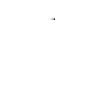

In [20]:
image_2d = new_image.view(28,28)
img = image_2d.cpu().detach().numpy()
plt.figure(figsize=(1, 1))
plt.imshow(img, cmap = 'gray')
plt.axis('off')  # Turn off axis
plt.show()